![title](https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png)

# Specreduce Demo
**Author : Camilla Pacifici, Space Telescope Science Institute**<br>
**Last update: May 27, 2025**

**Tutorial Overview**<br>
This tutorial will show the basic spectral extraction functionality in the Astropy package [Specreduce](https://specreduce.readthedocs.io/en/latest/). We will:

1. Get a 2D spectrum and look at it using Jdaviz/Specviz2d
2. Read the spectrum with Specutils/Spectrum1D
3. Calculate the trace 
4. Set up the background
5. Extract the 1D spectrum

## Import

In [1]:
# Jdaviz to visualize the spectrum
from jdaviz import Specviz2d
# Matplotlib for other plotting
from matplotlib import pyplot as plt
# Astropy to load the spectrum
from astropy.io import fits
from astropy import units as u
from astropy.nddata import StdDevUncertainty
# Astropy modeling for fitting
from astropy.modeling.models import Polynomial1D
# Specutils to manipulate the spectrum
from specutils import Spectrum1D
# Specreduce methods for tracing and extracting
from specreduce.tracing import FlatTrace, FitTrace
from specreduce.extract import BoxcarExtract

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-071
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## Data
Use the example spectrum provided or your own spectrum.

In [2]:
file = 'hlsp_jades_jwst_nirspec_goods-n-mediumhst-00000804_clear-prism_v1.0_s2d.fits'
uri = 'mast:HLSP/jades/dr3/goods-n/spectra/clear-prism/goods-n-mediumhst/hlsp_jades_jwst_nirspec_goods-n-mediumhst-00000804_clear-prism_v1.0_s2d.fits'

Load the spectrum in Specviz2d to take a look. As you can see, this is very convenient when you are working with a single spectrum.

In [3]:
viz = Specviz2d()
viz.load(uri)
viz.show()

INFO: Found cached file ./hlsp_jades_jwst_nirspec_goods-n-mediumhst-00000804_clear-prism_v1.0_s2d.fits with expected size 613440. [astroquery.query]


Application(config='specviz2d', docs_link='https://jdaviz.readthedocs.io/en/v4.4.1/specviz2d/index.html', even…

## Load the spectrum using Specutils
Here we take the spectrum and we load it with `Specutils`.
[Documentation for working with Spectrum1D in Specutils.](https://specutils.readthedocs.io/en/stable/spectrum1d.html)

First we open the file using `fits` from `atropy`, then we find all the relavant extensions and units. Lastly, we create the `Spectrum1D` object.

In [4]:
hdu = fits.open(file)
hdu.info()

Filename: hlsp_jades_jwst_nirspec_goods-n-mediumhst-00000804_clear-prism_v1.0_s2d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   ()      
  1  FLUX          1 ImageHDU         9   (674, 27)   float64   
  2  FLUX_ERR      1 ImageHDU         9   (674, 27)   float64   
  3  WAVELENGTH    1 ImageHDU         8   (674,)   float64   
  4  RA            1 ImageHDU         9   (674, 27)   float64   
  5  DEC           1 ImageHDU         9   (674, 27)   float64   
  6  ASDF          1 BinTableHDU      9   0R x 0C   []   


In [5]:
flux = hdu['FLUX'].data
fluxunit = u.Unit(hdu['FLUX'].header['GUNIT'])
fluxerr = hdu['FLUX_ERR'].data
fluxerrunit = u.Unit(hdu['FLUX_ERR'].header['UNIT'])
wave = hdu['WAVELENGTH'].data
waveunit = u.Unit(hdu['WAVELENGTH'].header['UNIT'])

spec2d = Spectrum1D(spectral_axis=wave*waveunit,
                    flux=flux*fluxunit,
                    uncertainty=StdDevUncertainty(fluxerr*fluxerrunit))

spec2d

        Use Spectrum instead. [warnings]


<Spectrum(flux=[[-8.71088874751965e-22 ... nan]] erg / (Angstrom s cm2) (shape=(27, 674), mean=-0.00000 erg / (Angstrom s cm2)); spectral_axis=<SpectralAxis [0.60255005 0.60515434 0.60776989 ... 5.29913789 5.30360628 5.30807845] um> (length=674); uncertainty=StdDevUncertainty)>

## Tracing
Now that we have the object ready, we can start the processing. First, we need to find the trace, which means finding the pixels where the object is the brightest along each cross-dispersion column. There are three methods to do tracing in `specreduce`: `ArrayTrace`, `FlatTrace`, and `FitTrace`. Here we demonstrate `FlatTrace` and `FitTrace`.

[Documentation for tracing with Specreduce.](https://specreduce.readthedocs.io/en/latest/extraction_quickstart.html#tracing)

In [6]:
trace = FlatTrace(spec2d, 14)
trace.trace_pos

14

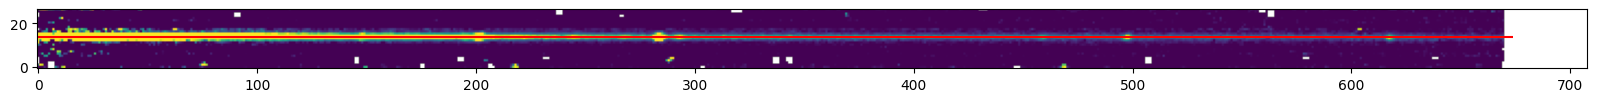

In [7]:
plt.figure(figsize=(20, 3))
plt.imshow(spec2d.flux, vmin=0, vmax=1E-20, origin='lower')
plt.hlines(trace.trace_pos, xmin=0, xmax=len(wave), color='red')
plt.show()

In [8]:
# tracefit = FitTrace?
tracefit = FitTrace(spec2d, bins=50,
                    guess=trace.trace_pos, # Position to start looking for the trace
                    window=10, # Window in cross dispersion direction
                    trace_model=Polynomial1D(1)) # Model used to fit the trace
# tracefit.trace.data

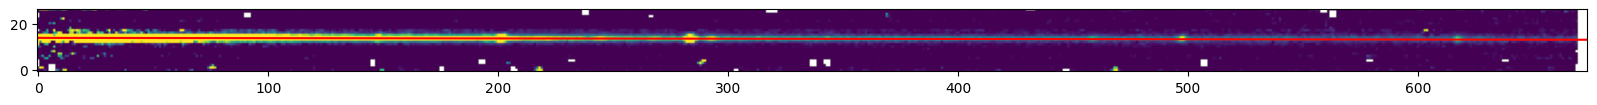

In [9]:
plt.figure(figsize=(20, 3))
plt.imshow(spec2d.flux, vmin=0, vmax=1E-20, origin='lower')
plt.plot(tracefit.trace.data, color='red')
plt.show()

## Background subtraction
Background subtraction is important to remove the signal coming from the Universe. Usually, background subtraction is done by taking the median signal in regions where there is no light coming from the object of interest and then subtracting this light from the object. Because of the way JWST observes (nodding) the background is already subtracted here. We show the calls, but we do not use them.
```
from specreduce.background import Background
bg = Background.two_sided(spec2d, tracefit, separation=7, width=3)
subtracted_image = spec2d - bg
```

[Documentation for background subtraction with Specreduce](https://specreduce.readthedocs.io/en/latest/extraction_quickstart.html#background)

## Extraction
The last step is the extraction, i.e. translating the 2D spectrum into a 1D spectrum. This essencially means collapsing the signal in the cross-dispersion direction in a smart way to obtain the maximum signal-to-noise ratio. `Specreduce` provides us with two methods for extraction: `BoxcarExtract` and `HorneExtract`. Here, we show how to run the first.

[Documentation for spectral extraction with Specreduce](https://specreduce.readthedocs.io/en/latest/extraction_quickstart.html#extraction)

In [10]:
# extract = BoxcarExtract?
extract = BoxcarExtract(spec2d,
                        tracefit,
                        width=5)
spec1d = extract.spectrum
spec1d

<Spectrum(flux=[1.4182971859414282e-19 ... nan] erg / (Angstrom s cm2) (shape=(674,), mean=0.00000 erg / (Angstrom s cm2)); spectral_axis=<SpectralAxis [0.60255005 0.60515434 0.60776989 ... 5.29913789 5.30360628 5.30807845] um> (length=674))>

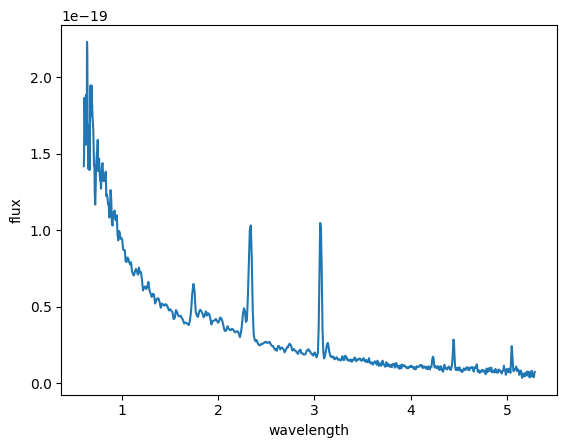

In [11]:
plt.plot(spec1d.spectral_axis, spec1d.flux)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()